In [ ]:
!pip install transformers

In [ ]:
import os.path
from urllib.request import urlretrieve

url = """https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"""
if not os.path.exists(url.split("/")[-1]):
    urlretrieve(url, url.split("/")[-1])
    print("Downloaded", url)

Downloaded https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")           # Assign a variable for running the training model in GPU when it is available
print(device)

cuda


In [ ]:
import tarfile
import numpy as np
import glob

tar = tarfile.open('aclImdb_v1.tar.gz')
tar.extractall()

train_X = []                                                                    # X is texts, y is integers (0 for negative texts or 1 for posirive texts)
train_y = []
test_X = []
test_y = []

def load_data(data_type):                                                       # Load dataset and generate seperated lists of training and test data.
  for c in ["pos", "neg"]:
    files = glob.glob(f"aclImdb/{data_type}/{c}/*.txt")
    for file in files: # files[:100]
      if data_type == "train":
        train_X.append(open(file, "r").read())
        train_y.append(1 if c == "pos" else 0)

      else:
        test_X.append(open(file, "r").read())
        test_y.append(1 if c == "pos" else 0)

load_data("train")
load_data("test")

print(len(train_X), len(train_y))
print(len(test_X), len(test_y))

25000 25000
25000 25000


In [ ]:
from transformers import DistilBertModel, DistilBertTokenizer                   # Import DistilBertModel and DistilTokenizer from Huggingface

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')      # Initinalize the tokenizer and model named by 'distilbert-base-uncased' (a transformer-based language model)
model = DistilBertModel.from_pretrained('distilbert-base-uncased')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
import torch
from torch.utils.data import Dataset

class NN_Dataset(Dataset):                                                      # A class to encode dataset
    def __init__(self, sentences, labels, tokenizer):
        self.sentences = sentences                                              # sentences are texts from raw review data
        self.labels = labels                                                    # labels are 0 or 1
        self.tokenizer = tokenizer                                              # Tokenizer initialized above

    def __len__(self):
        return len(self.sentences)                                              # It is used for idx to get items of text and label assigned in __getitem__ function

    def __getitem__(self, idx):
        text = self.sentences[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(                                  # Encode texts using tokenizer. We pad each sequence with the max length of a sequence of the data
            text,                                                               # With .encode_plus method can we use additional attributes of tokenizer like 'padding', 'truncation'.
            add_special_tokens=True,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {                                                                # Return a dictionary that consists of token IDs, attention masks and labels of input texts
            'input_ids': encoding['input_ids'].flatten().to(device),            # a list containing a sequence of token IDs corresponding to each input text
            'attention_mask': encoding['attention_mask'].flatten().to(device),  # a list containing a attention mask of each input text
            'labels': torch.tensor(label, dtype=torch.long).to(device)          # a list containing intergers, 0 or 1 corresponding to each input text
        }

In [ ]:
from torch.utils.data import DataLoader

batch_size = 128

train_dataset = NN_Dataset(train_X, train_y, tokenizer)                         # Build seperated datasets for training and test using Dataset class defined above
test_dataset = NN_Dataset(test_X, test_y, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)   # Initialize seperated data loaders using DataLoader class for training and test
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [ ]:
import torch
import torch.nn as nn

class DistilBERTForClassification(nn.Module):                                         # Neural network training model using DistilBert Model for text classification
    def __init__(self, num_labels, freeze_bert):
        super(DistilBERTForClassification, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')  # Initialize the model of DistilBertModel
        self.dropout = nn.Dropout(0.1)                                                # Set dropout with 0.1
        self.classifier = nn.Linear(768, num_labels)                                  # Set dimension size should match with the number of hidden size of DistilberModel's output, which is 768
        self.softmax = nn.Softmax(dim=1)

        if freeze_bert:                                                               # Set a condition whether the DistilBERT computes gradients for parameters during training or not.
            for param in self.distilbert.parameters():                                # If freeze_bert is True, the parameters of the model they won't be updated during training.
                param.requires_grad = False                                           # We can use it to reduce usage of GPU memory and get the training faster

    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state                           # Extract last_hidden_state tensor from the model's output where contins hidden state for each token in input sequence

        pooled_output = last_hidden_state[:, 0, :]                              # Pool CLS vector (first token of the hidden state) for each sequence in the batch
        pooled_output = self.dropout(pooled_output)                             # Apply dropout to the pooled output to prevent overfitting during training

        pooled_output_last = self.classifier(pooled_output)                     # Pass pooled output a linear layer to map it ot the number of labels
        score = self.softmax(pooled_output_last)                                # Use softmax activation function to get predicted ouputs
        return score

num_labels = 2
freeze_bert = True

model = DistilBERTForClassification(num_labels, freeze_bert)

model.to(device)                                                                # Run the model in GPU when it is available


DistilBERTForClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
         

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)                      # OR lr = 0.01
criterion = nn.CrossEntropyLoss()                                               # I used cross entropy loss function
num_epochs = 3

train_accuracy = []                                                             # Store training accuracies and losses for each epoch
train_loss = []

# Training loop
for epoch in range(num_epochs):                                                 # Set how many time to loop over training data
    model.train()                                                               # Run the model for training
    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for batch_idx, batch in enumerate(train_loader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask)                              # Pool socre of input sequences in the batch

        loss = criterion(outputs, labels)                                       # Calculate loss
        total_loss += loss.item()                                               # Sum all losses of each batch for calculation training loss of each epoch

        predicted_labels = outputs.argmax(dim=1, keepdim=True).squeeze()        # Compute predictions

        correct = (predicted_labels == labels).sum().item()
        accuracy = (correct / labels.size(0)) *100

        correct_predictions += correct                                          # Update counts for correct and total predictions of each batch for calculation training accuracy of each epoch
        total_predictions += labels.size(0)


        loss.backward()                                                         # Backward pass and optimization
        optimizer.step()

        train_accuracy.append(accuracy)                                         # Store all accuracies and losses of each epoch
        train_loss.append(loss.item())

    avg_loss= total_loss / len(train_loader)                                    # Calculate averages of accuracy and loss of each epoch
    avg_accuracy = (correct_predictions / total_predictions) *100


    print(f"Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {avg_loss:.1f}, Accuracy: {avg_accuracy:.1f}")

    torch.cuda.empty_cache()                                                    # Clean GPU cache after every epoch



Epoch [1/3], Batch [196/196], Loss: 0.7, Accuracy: 53.4
Epoch [2/3], Batch [196/196], Loss: 0.7, Accuracy: 57.0
Epoch [3/3], Batch [196/196], Loss: 0.7, Accuracy: 60.9


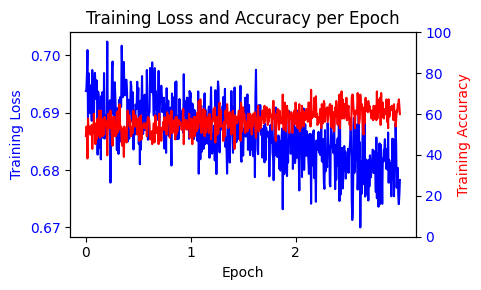

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracies and losses over all epochs

fig = plt.figure(figsize=(5, 3))
ax = plt.subplot()
ax.set_title('Training Loss and Accuracy per Epoch')
ax.plot(train_loss, 'b')
ax.tick_params(axis='y', labelcolor='b')

ax.set_xlabel('Epoch')
ax.set_ylabel('Training Loss', color='b')

ax = ax.twinx()

plt.plot(train_accuracy, 'r')
ax.set_ylabel('Training Accuracy', color='r')
ax.tick_params(axis='y', labelcolor='b')

a = list(ax.axis())
a[2] = 0
a[3] = 100
ax.axis(a)

c = np.arange(0, len(train_accuracy), len(train_X)//batch_size+1)
ax.set_xticks(c)
ax.set_xticklabels(labels=np.arange(len(c)))
fig.tight_layout()
plt.show()

In [ ]:
model.eval()                                                                    # Evaluate the model
with torch.no_grad():
    correct = 0
    total = 0
    for batch in test_loader:                                                   # Test the model using test dataset
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask)
        predicted_labels = outputs.argmax(dim=1, keepdim=True).squeeze()
        correct += (predicted_labels == labels).sum().item()
        total += labels.size(0)
        accuracy = (correct / total) * 100

print("Test accuracy %.1f%%" % accuracy)

torch.cuda.empty_cache()                                                        # Clean GPU cache after every epoch


"""
The hardest part of this assignment was understanding the concept to design network model using a pre-trained language model.
It required for me to do some researches what a transformer-base model is and how it can be used in neural network model.
I spent the most time to find out the way to implement the pre-trained model in neural network. Besides, to load the huge dataset was a bit challenging.
The data spreads over different folders so I needed to find the most efficient way to split dataset for train and test in pre-processing part.
Because of the relatively huge dataset, I also needed to manage about using the memmory when I tested my codes. I tried to cut down the data to 200 for train and test respectively for testing my codes,
but when I wanted to run the whole datset later, I faced the problem of memory usage. To solve this problem, I added a function to clean GPU cache in the training model (given as a tip in the instruction)
as well as a condition to freeze parameters of the model. After these modifications, I could run the models with the whole dataset using GPU.

The most fruitful thing for me to work on this assignment was that I've learned what Huggingface is and experienced to implement a transformer model to train a specific task (sentiment analysis).
"""

Test accuracy 69.9%


"\nThe hardest part of this assignment was understanding the concept to design network model using a pre-trained language model.\nIt required for me to do some researches what a transformer-base model is and how it can be used in neural network model.\nI spent the most time to find out the way to implement the pre-trained model in neural network. Besides, to load the huge dataset was a bit challenging.\nThe data spreads over different folders so I needed to find the most efficient way to split dataset for train and test in pre-processing part.\nBecause of the relatively huge dataset, I also needed to manage about using the memmory when I tested my codes. I tried to cut down the data to 200 for train and test respectively for testing my codes,\nbut when I wanted to run the whole datset later, I faced the problem of memory usage. To solve this problem, I added a function to clean GPU cache in the training model (given as a tip in the instruction)\nas well as a condition to freeze paramet